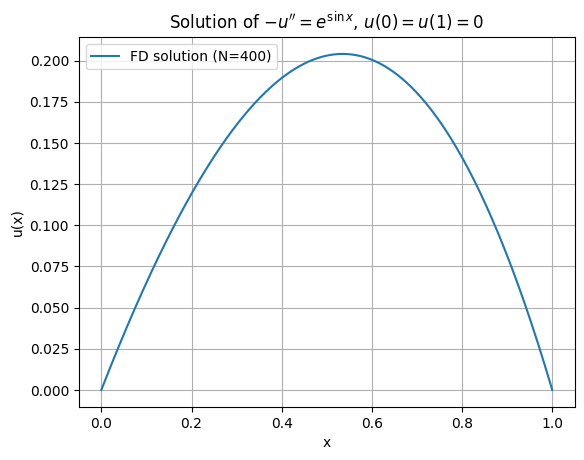

In [5]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def solve_dirichlet_poisson_1d(f, a=0.0, b=1.0, N=200, alpha=0.0, beta=0.0):
    
    h = (b - a) / N
    x = np.linspace(a, b, N+1)

    # interior nodes and RHS
    xi = x[1:-1]
    rhs = f(xi)

    # build tridiagonal matrix A (size (N-1)x(N-1))
    main = 2.0*np.ones(N-1) / h**2
    off  = -1.0*np.ones(N-2) / h**2
    A = diags([off, main, off], offsets=[-1, 0, 1], format='csc')

    # add Dirichlet boundary contributions (in case that alpha, beta are not 0)
    rhs[0]  += alpha / h**2
    rhs[-1] += beta  / h**2

    # solve
    u_interior = spsolve(A, rhs)

    # assemble full solution
    u = np.empty_like(x)
    u[0], u[-1] = alpha, beta
    u[1:-1] = u_interior
    return x, u

# ---- problem-specific f(x) and solve once ----
f, a, b, N, alpha, beta = lambda x: np.exp(np.sin(x)), 0.0, 1.0, 400, 0.0, 0.0

x, u = solve_dirichlet_poisson_1d(f, a, b, N, alpha, beta)

# quick check: plot the solution
plt.figure()
plt.grid()
plt.plot(x, u, label=f"FD solution (N={N})")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r"Solution of $-u''=e^{\sin x}$, $u(0)=u(1)=0$")
plt.legend()
plt.show()

N=  50: Linf=1.764e-06, L2=1.135e-06, observed order≈ nan
N= 100: Linf=4.408e-07, L2=2.838e-07, observed order≈ 2.00
N= 200: Linf=1.102e-07, L2=7.093e-08, observed order≈ 2.00
N= 400: Linf=2.753e-08, L2=1.772e-08, observed order≈ 2.00
N= 800: Linf=6.860e-09, L2=4.415e-09, observed order≈ 2.00
N=1600: Linf=1.693e-09, L2=1.090e-09, observed order≈ 2.02
N=3200: Linf=4.016e-10, L2=2.586e-10, observed order≈ 2.08
N=6400: Linf=7.920e-11, L2=5.128e-11, observed order≈ 2.34


/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_6225/2310831038.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  errs_l2.append(np.sqrt(np.trapz(diff**2, xs[k])))


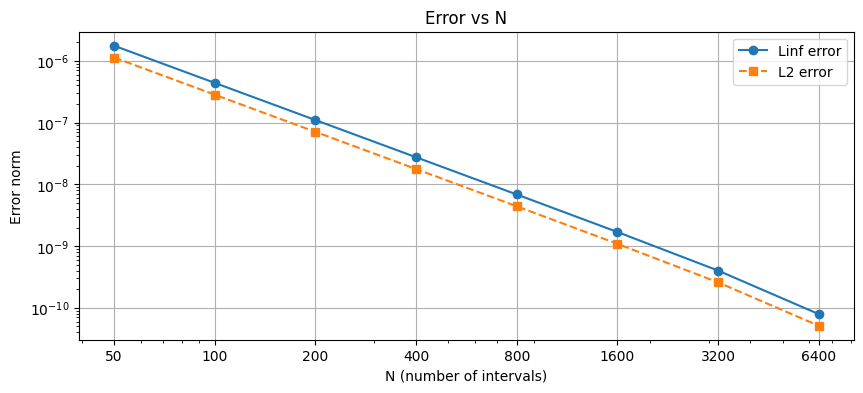

In [14]:
# ---- (optional) grid-refinement study to see ~O(h^2) ----
def restrict_even(u_fine):
    # keep every other point (fine has 2N intervals, coarse has N)
    return u_fine[::2]

def refinement_study(N_list=(50, 100, 200, 400, 800, 1600, 3200, 6400, 12800)):
    sols = []
    xs = []
    for N in N_list:
        xN, uN = solve_dirichlet_poisson_1d(f, N=N, alpha=0.0, beta=0.0)
        xs.append(xN); sols.append(uN)
    # use the finest grid as reference, compare coarse vs restricted fine
    errs_inf, errs_l2, rates = [], [], []
    for k in range(len(N_list)-1):
        u_coarse = sols[k]
        u_fine   = sols[-1]
        # restrict finest to coarse nodes
        factor = (N_list[-1] // N_list[k])
        u_ref_on_coarse = u_fine[::factor]
        diff = u_coarse - u_ref_on_coarse
        errs_inf.append(np.max(np.abs(diff)))
        errs_l2.append(np.sqrt(np.trapz(diff**2, xs[k])))
        if k>0:
            # empirical rate ~ log(E_k/E_{k-1}) / log(h_k/h_{k-1}) ; but here h halves each time
            rates.append(np.log(errs_inf[k]/errs_inf[k-1]) / np.log(0.5))
        else:
            rates.append(np.nan)
    return np.array(errs_inf), np.array(errs_l2), np.array(rates), N_list[:-1]

errs_inf, errs_l2, rates, Ns = refinement_study()
for N, eI, e2, r in zip(Ns, errs_inf, errs_l2, rates):
    print(f"N={N:4d}: Linf={eI:.3e}, L2={e2:.3e}, observed order≈ {r:.2f}")


plt.figure(figsize=(10,4))
plt.loglog(Ns, errs_inf, 'o-', label='Linf error')
plt.loglog(Ns, errs_l2, 's--', label='L2 error')
plt.xticks(Ns, Ns)
plt.xlabel('N (number of intervals)')
plt.ylabel('Error norm')
plt.title('Error vs N')
plt.grid()
plt.legend()
